<a href="https://colab.research.google.com/github/abidur0177/TIme-Series-Prediction/blob/main/Predict_time_series_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this project, I will be using the same time series data but a RNN will be deployed instead of DNN

### Import the libraries and define the utility functions

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [41]:
# Define the series plotting function
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Define the trend line
def trend(time, slope=0):

    # Compute the linear series given the slope
    series = slope * time

    return series

# Define a random seasonal pattern
def seasonal_pattern(season_time):

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.3,
                    np.sin(season_time * 1.68 * np.pi),
                    1.7 / np.exp(2.34 * season_time))

    return data_pattern

# Define the seasonality
def seasonality(time, period, amplitude=2.5, phase=0):

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Define the noise
def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate the date and split it into training and validation set

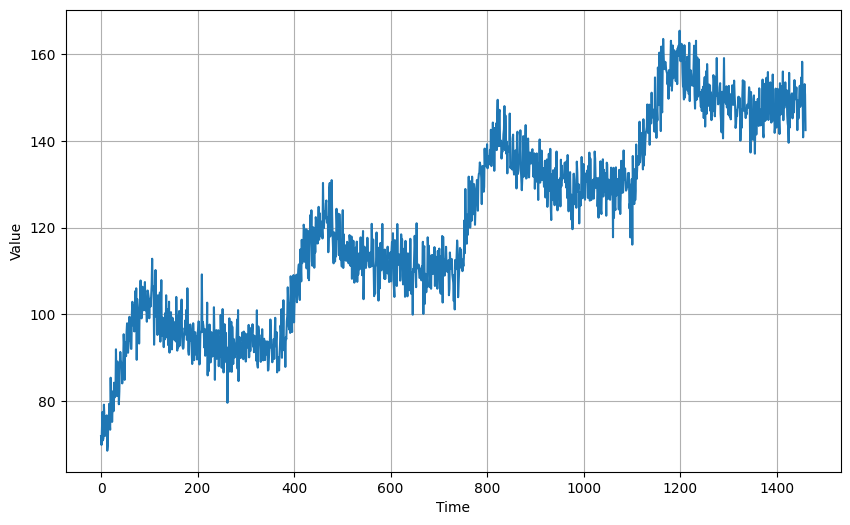

In [42]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 70
amplitude = 30
slope = 0.05
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

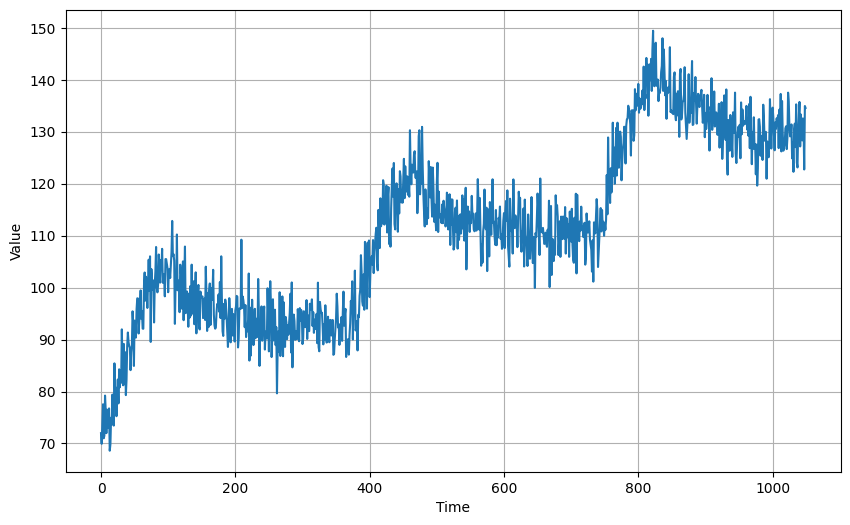

In [43]:
# Define the split time
split_time = 1050

# Get the train set
time_train = time[:split_time]
series_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
series_valid = series[split_time:]


# Plot the train set
plot_series(time_train, series_train)


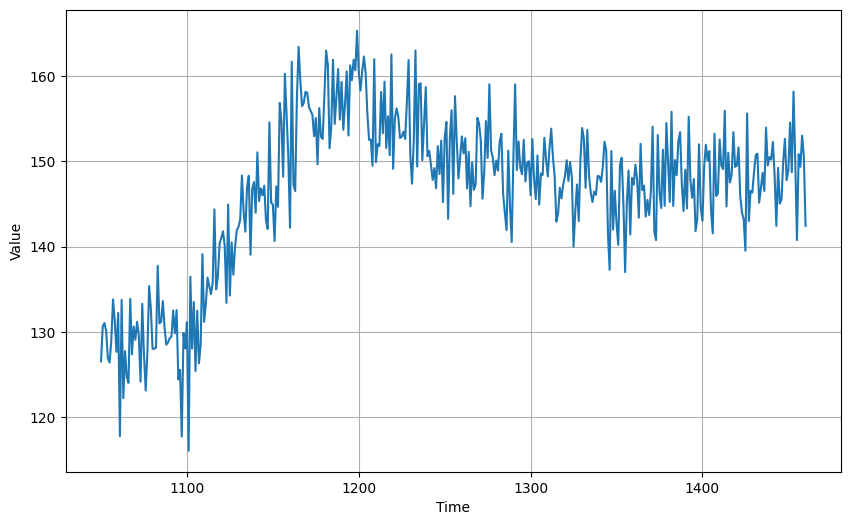

In [44]:
# Plot the validation set
plot_series(time_valid, series_valid)

### Generate features and labels

In [45]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1500


# Generate a windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [46]:
# Generate the dataset windows
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

In [47]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


### Build and compile the model with a tunable learning rate

In [48]:
# Build the model
model = keras.Sequential([
    keras.layers.Lambda(lambda input: tf.expand_dims(input, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*100)
])

# See the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_16 (Lambda)          (None, None, 1)           0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, None, 40)          1680      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_8 (Dense)             (None, 1)                 41        
                                                                 
 lambda_17 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
33/33 [==============================] - 4s 18ms/step - loss: 338.5049 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 16ms/step - loss: 335.3016 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 13ms/step - loss: 331.3995 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 326.9147 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 321.6495 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 314.9843 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 305.8918 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 9ms/step - loss: 296.3062 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 9ms/step - loss: 287.5964 - lr: 2.5119e-08
Epoch 10/100
33/33 [==============================] - 0s 9ms/step - loss: 278.6650 - lr: 2.8184e-08
Epoch 

(1e-08, 0.001, 0.0, 50.0)

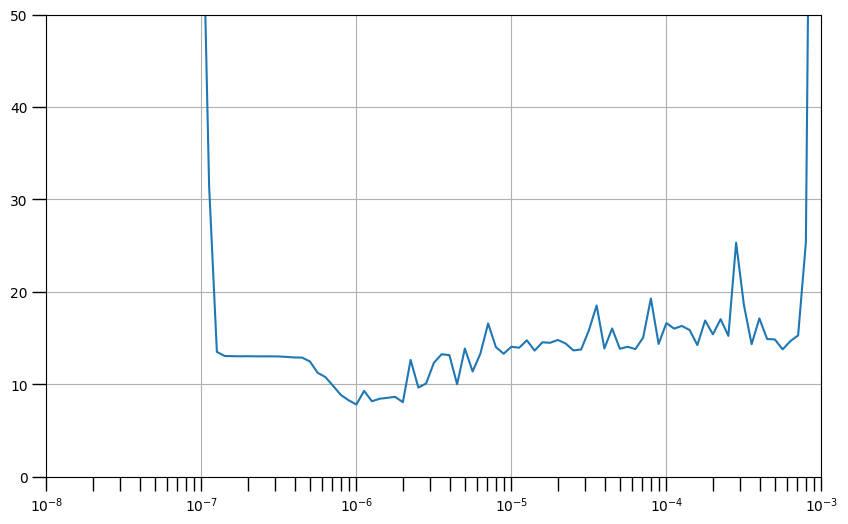

In [50]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

### Train the model again with the appropriate learning rate

In [51]:
# Get the index of the minimum loss value
loss_min = np.argmin(history.history['loss'])

# Get the learning rate from that position
lr = lrs[loss_min]
lr

1e-06

In [52]:
# Build the model
model = keras.Sequential([
    keras.layers.Lambda(lambda input: tf.expand_dims(input, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*100.0)
])

# See the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, None, 1)           0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, None, 40)          1680      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                 
 lambda_19 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Set the learning rate for compiling the model
model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9), metrics=['mae'])

# Train the model for 100 epochs
history = model.fit(dataset, epochs=100)

Epoch 1/100
33/33 [==============================] - 2s 10ms/step - loss: 28.5723 - mae: 29.0678
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 13.1913 - mae: 13.6796
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 13.1434 - mae: 13.6354
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 13.1346 - mae: 13.6261
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 12.8865 - mae: 13.3780
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 12.4983 - mae: 12.9870
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 12.4259 - mae: 12.9158
Epoch 8/100
33/33 [==============================] - 0s 9ms/step - loss: 12.2158 - mae: 12.7055
Epoch 9/100
33/33 [==============================] - 0s 9ms/step - loss: 11.0784 - mae: 11.5697
Epoch 10/100
33/33 [==============================] - 0s 9ms/step - loss: 9.9226 - mae: 10.4150
Epoch 11/100
33/33 [==================

1/1 [==============================] - 0s 32ms/step


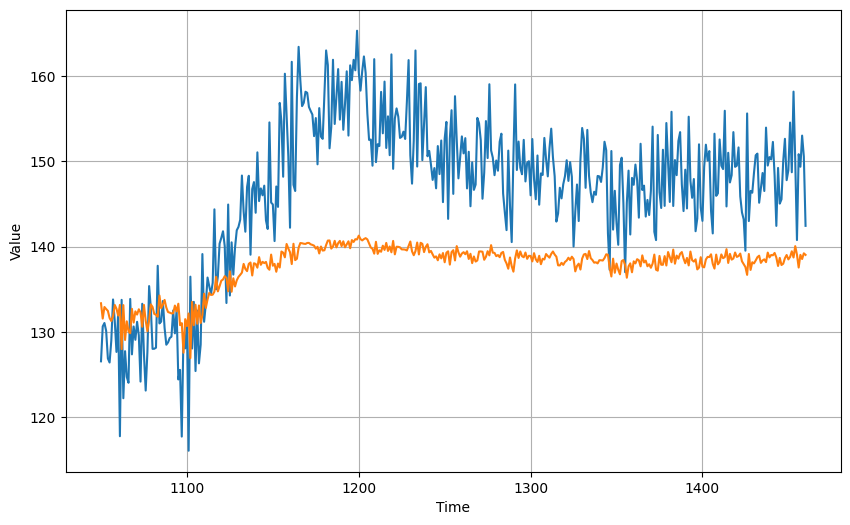

In [54]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [55]:
# We can define a function to fast process the prediction
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

13/13 [==============================] - 1s 20ms/step


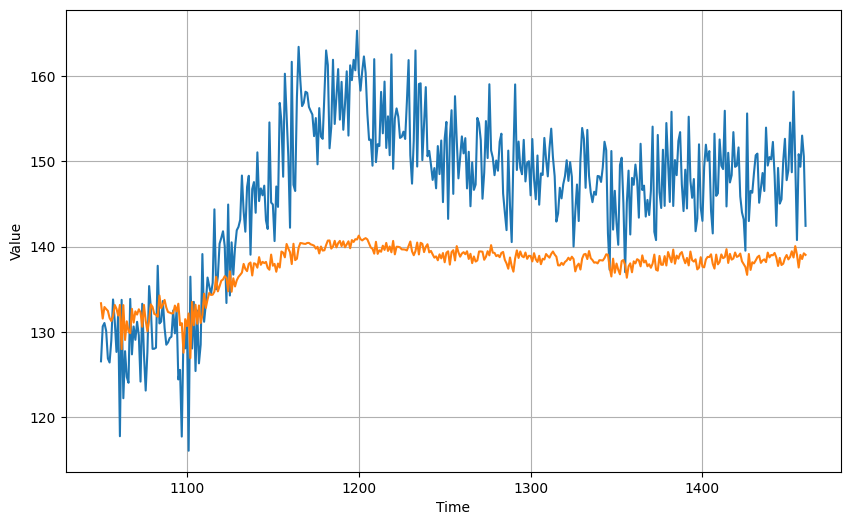

In [56]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [58]:
# See the error metrices
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

128.71036
9.955239
